# Baseline Model w/ only numerical data

## 1. Import Dependencies

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler #Use RobustScaler if data has a lot of outliers
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

## 2. Import Dataset

In [9]:
df = pd.read_csv('../data/tese.csv', sep='|') 

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   account_id                                  50000 non-null  object 
 1   country_name                                50000 non-null  object 
 2   account_category                            50000 non-null  object 
 3   bi_account_classification                   50000 non-null  object 
 4   customer_type                               50000 non-null  object 
 5   company_name                                49995 non-null  object 
 6   domain                                      49945 non-null  object 
 7   city                                        49965 non-null  object 
 8   sic_code                                    22107 non-null  float64
 9   companydataprovider_companyname             34549 non-null  object 
 10  companydat

In [11]:
df.head()

,account_id,country_name,account_category,bi_account_classification,customer_type,company_name,domain,city,sic_code,companydataprovider_companyname,...,age_customer,number_renewals,number_total_invoices,account_value_in_eur,revenue_last_12_month,years_purchased,billings_ltm_prorated,business_model,is_subscription,is_customer_perpetual
0,3609465D-A808-EB11-95AA-005056A7C91D,Brazil,Standard,Inside Sales,Customer,Guaçu S/A Papeis e Embalagens,@guacu.com.br,estiva gerbi,NaN,NaN,...,3,3,4,822.49,215.03,8086,215.03,S,True,False
1,3657E19B-FD1A-E411-80D3-005056846F2F,Germany,Standard,Inside Sales,Customer,Stadtwerke Bad Schwalbach,@bad-schwalbach.de,Bad Schwalbach,NaN,Stadtwerke Schwalbach/Taunus,...,9,2,4,2937.39,837.22,8080,837.22,S,True,False
2,8451D3C3-FC1A-E411-80D3-005056846F2F,Italy,Standard,Inside Sales,Customer,Prussiani Engineering s.r.l.,@prussiani.com,Albano Sant'Alessandro,3559.0,PRUSSIANI ENGINEERING SPA,...,13,2,6,5884.78,1157.72,12106,1157.72,S,True,False
3,B6B0B074-213F-ED11-9DB0-000D3ADEAD35,Netherlands,Standard,Inside Sales,Customer,Kadoelenwerf Jachtservice & Haven,@hotmail.com,Amsterdam,4493.0,Jachthaven Kadoelenwerf c.v.,...,1,1,2,861.84,478.80,4045,478.80,S,True,False
4,3151AAFA-F21A-E411-80D3-005056846F2F,Switzerland,Standard,Inside Sales,Customer,Casinò Lugano SA,@casinolugano.ch,Lugano,7999.0,Casinò Lugano SA,...,12,5,7,3538.54,533.25,14134,533.25,S,True,False


## 3. Data Preprocessing

### 3.1. Add SIC Code & Description

In [12]:
df_sic_codes = pd.read_excel('../data/sic_4_digit_codes.xls')

In [13]:
df_sic_codes

,Code Value,Description
0,111,Wheat
1,112,Rice
2,115,Corn
3,116,Soybeans
4,119,"Cash grains, nec"
...,...,...
1000,9651,"Regulation, miscellaneous commercial sectors"
1001,9661,Space research and technology
1002,9711,National security
1003,9721,International affairs


In [14]:
# Merge df and df_sic_codes and add the 'description' column to df
df = df.merge(df_sic_codes, left_on='sic_code', right_on='Code Value', how='left')

In [15]:
# Rename the 'description' column to 'code_description'
df.rename(columns={'Description': 'sic_code_description'}, inplace=True)

### 3.2. Add Industry

In [16]:
# Define a dictionary to map SIC code ranges to major industry groups
major_groups = {
    range(1, 10): 'Agriculture, Forestry, and Fishing',
    range(10, 15): 'Mining',
    range(15, 18): 'Construction',
    range(20, 40): 'Manufacturing',
    range(40, 50): 'Transportation, Communications, Electric, Gas, and Sanitary Services',
    range(50, 53): 'Wholesale Trade',
    range(52, 60): 'Retail Trade',
    range(60, 68): 'Finance, Insurance, and Real Estate',
    range(70, 90): 'Services',
    range(90, 100): 'Public Administration'
}

# Map SIC code ranges to major industry group descriptions
def map_to_major_group(sic_code):
    for group_range, description in major_groups.items():
        if sic_code // 100 in group_range:
            return description
    return 'Unknown'

In [17]:
df['industry'] = df['sic_code'].apply(map_to_major_group)

In [18]:
df.head()

,account_id,country_name,account_category,bi_account_classification,customer_type,company_name,domain,city,sic_code,companydataprovider_companyname,...,account_value_in_eur,revenue_last_12_month,years_purchased,billings_ltm_prorated,business_model,is_subscription,is_customer_perpetual,Code Value,sic_code_description,industry
0,3609465D-A808-EB11-95AA-005056A7C91D,Brazil,Standard,Inside Sales,Customer,Guaçu S/A Papeis e Embalagens,@guacu.com.br,estiva gerbi,NaN,NaN,...,822.49,215.03,8086,215.03,S,True,False,NaN,NaN,Unknown
1,3657E19B-FD1A-E411-80D3-005056846F2F,Germany,Standard,Inside Sales,Customer,Stadtwerke Bad Schwalbach,@bad-schwalbach.de,Bad Schwalbach,NaN,Stadtwerke Schwalbach/Taunus,...,2937.39,837.22,8080,837.22,S,True,False,NaN,NaN,Unknown
2,8451D3C3-FC1A-E411-80D3-005056846F2F,Italy,Standard,Inside Sales,Customer,Prussiani Engineering s.r.l.,@prussiani.com,Albano Sant'Alessandro,3559.0,PRUSSIANI ENGINEERING SPA,...,5884.78,1157.72,12106,1157.72,S,True,False,3559.0,"Special industry machinery, nec",Manufacturing
3,B6B0B074-213F-ED11-9DB0-000D3ADEAD35,Netherlands,Standard,Inside Sales,Customer,Kadoelenwerf Jachtservice & Haven,@hotmail.com,Amsterdam,4493.0,Jachthaven Kadoelenwerf c.v.,...,861.84,478.80,4045,478.80,S,True,False,4493.0,Marinas,"Transportation, Communications, Electric, Gas,..."
4,3151AAFA-F21A-E411-80D3-005056846F2F,Switzerland,Standard,Inside Sales,Customer,Casinò Lugano SA,@casinolugano.ch,Lugano,7999.0,Casinò Lugano SA,...,3538.54,533.25,14134,533.25,S,True,False,7999.0,"Amusement and recreation, nec",Services


### 3.3. Cleaning

We will be working with only *non-null* values.

In [19]:
df = df.dropna()

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18150 entries, 2 to 49998
Data columns (total 56 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   account_id                                  18150 non-null  object 
 1   country_name                                18150 non-null  object 
 2   account_category                            18150 non-null  object 
 3   bi_account_classification                   18150 non-null  object 
 4   customer_type                               18150 non-null  object 
 5   company_name                                18150 non-null  object 
 6   domain                                      18150 non-null  object 
 7   city                                        18150 non-null  object 
 8   sic_code                                    18150 non-null  float64
 9   companydataprovider_companyname             18150 non-null  object 
 10  companydat

In [55]:
# Separate numerical features
num_data = df.select_dtypes(include=['float64', 'int64'])

# Combining the account_id column and numerical features
id_column = df['account_id']
data = pd.concat([id_column, num_data], axis=1)

In [56]:
data

,account_id,sic_code,companydataprovider_siccode,companydataprovider_employeenumber,companydataprovider_revenue_in_eur,number_distinct_active_licenses,initial_version,current_version,number_rm_licenses,number_rm_malwarebytes_endpoint_protection,...,total_devices_12m,days_from_last_invoice,age_customer,number_renewals,number_total_invoices,account_value_in_eur,revenue_last_12_month,years_purchased,billings_ltm_prorated,Code Value
2,8451D3C3-FC1A-E411-80D3-005056846F2F,3559.0,3559.0,52.0,15379307.0,3,10.0,-1,0,0,...,21,85,13,2,6,5884.78,1157.72,12106,1157.72,3559.0
3,B6B0B074-213F-ED11-9DB0-000D3ADEAD35,4493.0,4493.0,3.0,82742.0,1,-1.0,-1,0,0,...,2,57,1,1,2,861.84,478.80,4045,478.80,4493.0
4,3151AAFA-F21A-E411-80D3-005056846F2F,7999.0,7999.0,242.0,15454197.0,1,-1.0,-1,0,0,...,3,149,12,5,7,3538.54,533.25,14134,533.25,7999.0
5,7CA97D7A-A1F0-EC11-BB3D-000D3AB57339,5813.0,5813.0,7.0,830000.0,1,-1.0,-1,0,0,...,7,157,1,1,2,311.79,152.72,4045,152.72,5813.0
7,FFE48D4C-A666-EA11-A811-000D3AB11761,4212.0,4212.0,21.0,985411.0,1,-1.0,-1,0,0,...,0,254,3,3,4,475.20,118.80,8086,118.80,4212.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49969,9DC5CDED-C898-ED11-AAD1-000D3ADEA83D,4953.0,4953.0,9.0,3111000.0,1,-1.0,-1,0,0,...,16,161,0,0,2,266.42,266.42,4046,266.42,4953.0
49973,D0B6E4F9-E81A-E411-80D3-005056846F2F,7374.0,7374.0,105.0,18900000.0,3,15.0,-1,0,0,...,168,185,13,7,12,34539.78,4914.17,24205,4914.15,7374.0
49981,8CD2F113-BF75-EB11-A812-000D3AB25E8C,1721.0,1721.0,7.0,930779.0,1,-1.0,-1,0,0,...,2,272,2,2,3,1109.12,391.52,6066,391.52,1721.0
49994,95C51C1D-A4D6-E711-80EF-005056844077,8999.0,6111.0,5.0,954000.0,2,-1.0,-1,0,0,...,22,293,10,4,15,28771.99,4683.27,24215,4683.26,8999.0


### 3.4. Feature Selection

Write a little explanation about the selection method.

In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18150 entries, 2 to 49998
Data columns (total 37 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   account_id                                  18150 non-null  object 
 1   sic_code                                    18150 non-null  float64
 2   companydataprovider_siccode                 18150 non-null  float64
 3   companydataprovider_employeenumber          18150 non-null  float64
 4   companydataprovider_revenue_in_eur          18150 non-null  float64
 5   number_distinct_active_licenses             18150 non-null  int64  
 6   initial_version                             18150 non-null  float64
 7   current_version                             18150 non-null  int64  
 8   number_rm_licenses                          18150 non-null  int64  
 9   number_rm_malwarebytes_endpoint_protection  18150 non-null  int64  
 10  number_pil

In [60]:
numerical_features = ['account_id', 'companydataprovider_employeenumber', 'companydataprovider_revenue_in_eur', 'number_distinct_active_licenses',
       'total_connections_12m', 'total_endpoints_12m', 'total_devices_12m', 'days_from_last_invoice', 'age_customer', 'number_renewals', 
       'number_total_invoices', 'account_value_in_eur', 'revenue_last_12_month', 'years_purchased', 'billings_ltm_prorated']

data = data[numerical_features].copy()

data

,account_id,companydataprovider_employeenumber,companydataprovider_revenue_in_eur,number_distinct_active_licenses,total_connections_12m,total_endpoints_12m,total_devices_12m,days_from_last_invoice,age_customer,number_renewals,number_total_invoices,account_value_in_eur,revenue_last_12_month,years_purchased,billings_ltm_prorated
2,8451D3C3-FC1A-E411-80D3-005056846F2F,52.0,15379307.0,3,3349,611,21,85,13,2,6,5884.78,1157.72,12106,1157.72
3,B6B0B074-213F-ED11-9DB0-000D3ADEAD35,3.0,82742.0,1,78,4,2,57,1,1,2,861.84,478.80,4045,478.80
4,3151AAFA-F21A-E411-80D3-005056846F2F,242.0,15454197.0,1,243,33,3,149,12,5,7,3538.54,533.25,14134,533.25
5,7CA97D7A-A1F0-EC11-BB3D-000D3AB57339,7.0,830000.0,1,944,5,7,157,1,1,2,311.79,152.72,4045,152.72
7,FFE48D4C-A666-EA11-A811-000D3AB11761,21.0,985411.0,1,0,0,0,254,3,3,4,475.20,118.80,8086,118.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49969,9DC5CDED-C898-ED11-AAD1-000D3ADEA83D,9.0,3111000.0,1,297,7,16,161,0,0,2,266.42,266.42,4046,266.42
49973,D0B6E4F9-E81A-E411-80D3-005056846F2F,105.0,18900000.0,3,3512,1578,168,185,13,7,12,34539.78,4914.17,24205,4914.15
49981,8CD2F113-BF75-EB11-A812-000D3AB25E8C,7.0,930779.0,1,561,9,2,272,2,2,3,1109.12,391.52,6066,391.52
49994,95C51C1D-A4D6-E711-80EF-005056844077,5.0,954000.0,2,775,89,22,293,10,4,15,28771.99,4683.27,24215,4683.26


### 3.5. Feature Engineering

In [61]:
# Select the features (excluding the ID column)
features = data.iloc[:, 1:]

features

,companydataprovider_employeenumber,companydataprovider_revenue_in_eur,number_distinct_active_licenses,total_connections_12m,total_endpoints_12m,total_devices_12m,days_from_last_invoice,age_customer,number_renewals,number_total_invoices,account_value_in_eur,revenue_last_12_month,years_purchased,billings_ltm_prorated
2,52.0,15379307.0,3,3349,611,21,85,13,2,6,5884.78,1157.72,12106,1157.72
3,3.0,82742.0,1,78,4,2,57,1,1,2,861.84,478.80,4045,478.80
4,242.0,15454197.0,1,243,33,3,149,12,5,7,3538.54,533.25,14134,533.25
5,7.0,830000.0,1,944,5,7,157,1,1,2,311.79,152.72,4045,152.72
7,21.0,985411.0,1,0,0,0,254,3,3,4,475.20,118.80,8086,118.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49969,9.0,3111000.0,1,297,7,16,161,0,0,2,266.42,266.42,4046,266.42
49973,105.0,18900000.0,3,3512,1578,168,185,13,7,12,34539.78,4914.17,24205,4914.15
49981,7.0,930779.0,1,561,9,2,272,2,2,3,1109.12,391.52,6066,391.52
49994,5.0,954000.0,2,775,89,22,293,10,4,15,28771.99,4683.27,24215,4683.26


In [62]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18150 entries, 2 to 49998
Data columns (total 14 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   companydataprovider_employeenumber  18150 non-null  float64
 1   companydataprovider_revenue_in_eur  18150 non-null  float64
 2   number_distinct_active_licenses     18150 non-null  int64  
 3   total_connections_12m               18150 non-null  int64  
 4   total_endpoints_12m                 18150 non-null  int64  
 5   total_devices_12m                   18150 non-null  int64  
 6   days_from_last_invoice              18150 non-null  int64  
 7   age_customer                        18150 non-null  int64  
 8   number_renewals                     18150 non-null  int64  
 9   number_total_invoices               18150 non-null  int64  
 10  account_value_in_eur                18150 non-null  float64
 11  revenue_last_12_month               18150

In [44]:
# Create a standardization object
scaler = StandardScaler()

# Fit the scaler on the features
features_scaled = scaler.fit_transform(features)

### 3.6. Determine the number of clusters(k)

In [49]:
# Define a range of k values to test
k_range = range(1, 10)  # You can adjust this range

# Create a list to store WCSS values
wcss = []

for k in k_range:
  # Create a KMeans object with the current k value
  kmeans = KMeans(n_clusters=k, random_state=0)
  # Fit the model on the scaled features
  kmeans.fit(features_scaled)
  # Get the WCSS value (inertia_)
  wcss.append(kmeans.inertia_)

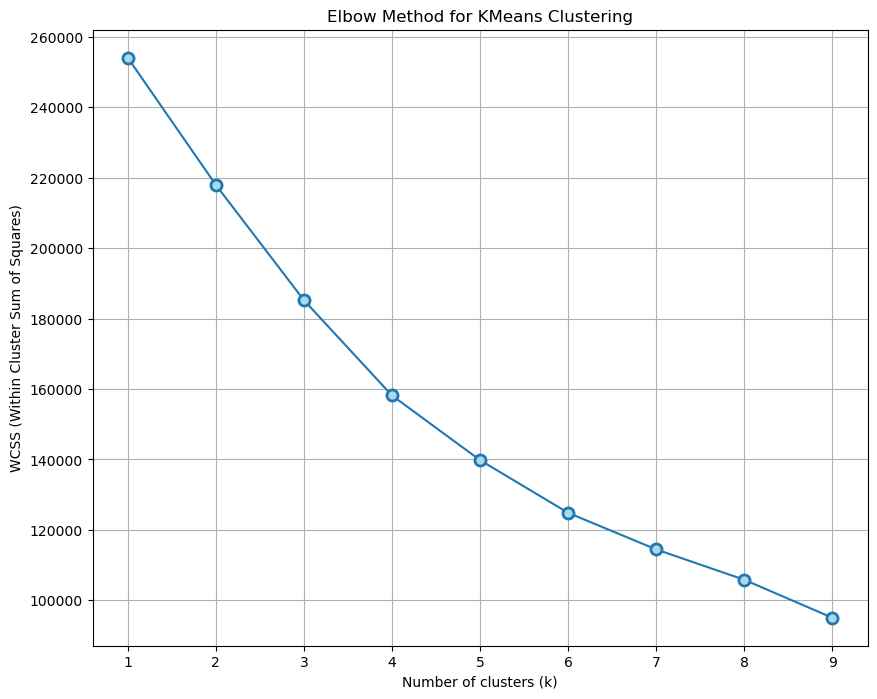

In [50]:
# Plot the WCSS vs k to identify the elbow point
plt.figure(figsize=(10, 8))
plt.plot(k_range, wcss, 'o-', markerfacecolor='lightblue', markeredgewidth=2, markersize=8)
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Within Cluster Sum of Squares)')
plt.title('Elbow Method for KMeans Clustering')
plt.grid(True)
plt.show()

## 4. Modeling

### 4.1. KMeans

In [51]:
# Assuming k=5 based on the Elbow Method
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(features_scaled)

# Get the cluster labels for each data point
cluster_labels = kmeans.labels_

In [65]:
# Get the first two features for plotting (assuming 2D data)
feature1 = features.iloc[:, 0]
feature2 = features.iloc[:, 1]

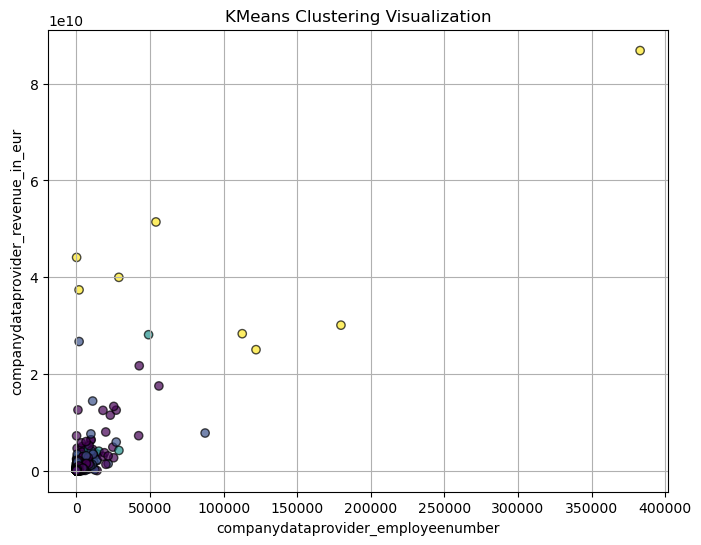

In [66]:
# Create a scatter plot with different colors for each cluster
plt.figure(figsize=(8, 6))
plt.scatter(feature1, feature2, c=cluster_labels, cmap='viridis', edgecolors='k', alpha=0.7)
plt.xlabel(features.columns[0])  # Assuming feature names are in the columns
plt.ylabel(features.columns[1])
plt.title('KMeans Clustering Visualization')
plt.grid(True)
plt.show()

### 4.2. DBSCAN

In [ ]:
# Create visualization of the clusters

## 5. Evaluation

### 5.1. KMeans

In [52]:
silhouette_score(features_scaled, cluster_labels)

0.41163754126815194

In [64]:
data['cluster'] = cluster_labels

data

,account_id,companydataprovider_employeenumber,companydataprovider_revenue_in_eur,number_distinct_active_licenses,total_connections_12m,total_endpoints_12m,total_devices_12m,days_from_last_invoice,age_customer,number_renewals,number_total_invoices,account_value_in_eur,revenue_last_12_month,years_purchased,billings_ltm_prorated,cluster
2,8451D3C3-FC1A-E411-80D3-005056846F2F,52.0,15379307.0,3,3349,611,21,85,13,2,6,5884.78,1157.72,12106,1157.72,1
3,B6B0B074-213F-ED11-9DB0-000D3ADEAD35,3.0,82742.0,1,78,4,2,57,1,1,2,861.84,478.80,4045,478.80,0
4,3151AAFA-F21A-E411-80D3-005056846F2F,242.0,15454197.0,1,243,33,3,149,12,5,7,3538.54,533.25,14134,533.25,1
5,7CA97D7A-A1F0-EC11-BB3D-000D3AB57339,7.0,830000.0,1,944,5,7,157,1,1,2,311.79,152.72,4045,152.72,0
7,FFE48D4C-A666-EA11-A811-000D3AB11761,21.0,985411.0,1,0,0,0,254,3,3,4,475.20,118.80,8086,118.80,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49969,9DC5CDED-C898-ED11-AAD1-000D3ADEA83D,9.0,3111000.0,1,297,7,16,161,0,0,2,266.42,266.42,4046,266.42,0
49973,D0B6E4F9-E81A-E411-80D3-005056846F2F,105.0,18900000.0,3,3512,1578,168,185,13,7,12,34539.78,4914.17,24205,4914.15,1
49981,8CD2F113-BF75-EB11-A812-000D3AB25E8C,7.0,930779.0,1,561,9,2,272,2,2,3,1109.12,391.52,6066,391.52,0
49994,95C51C1D-A4D6-E711-80EF-005056844077,5.0,954000.0,2,775,89,22,293,10,4,15,28771.99,4683.27,24215,4683.26,1
